In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap

import anndata
import scanpy as sc
from scvedge.vedge_model import VEDGE
import scvi
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
#import alluvial

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [3]:
adata = anndata.read_h5ad("../Data/mixed_source_adata.h5ad.gz")
VEDGE.setup_anndata(adata, batch_key='source', categorical_covariate_keys=['rep', 'tech'])
mvi = VEDGE.load("../model_trained/mix_source_vedge", adata)
adata.obsm["X_vedge"] = mvi.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_vedge")
sc.tl.umap(adata, min_dist=0.2)

INFO     File ../model_trained/mix_source_vedge/model.pt already downloaded                                        


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [12]:
adata.obs["final_ct"] = adata.obs.celltype.copy()
## relabel and collapse Ding annotations to existing Satpathy annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("CD14+ monocyte", "Monocyte")
    .replace("CD16+ monocyte", "Monocyte")
    .replace("Natural killer cell", "NK Cell")
    .replace("Cytotoxic T cell", "CD8+ T Cell")
    .replace("CD4+ T cell", "CD4+ T Cell")
    .replace("Plasmacytoid dendritic cell", "pDC")
    .replace("Dendritic cell", "Dendritic Cell")
    .replace("B cell", "B Cell")
)
## relabel and collapse Satpathy annotations to match existing Ding annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("Monocytes", "Monocyte")
    .replace("NK_Cells", "NK Cell")
    .replace("Naive_CD8_T_Cells", "CD8+ T Cell")
    .replace("Memory_CD8_T_Cells", "CD8+ T Cell")
    .replace("Naive_CD4_T_Cells", "CD4+ T Cell")
    .replace("Memory_CD4_T_Cells", "CD4+ T Cell")
    .replace("CD4_HelperT", "CD4+ T Cell")
    .replace("BM_pDC", "pDC")
    .replace("Dendritic_Cells", "Dendritic Cell")
    .replace("B_Cells", "B Cell")
    .replace("Regulatory_T_Cells", "TRegs")
)
adata.obs.final_ct = adata.obs.final_ct.replace("Unassigned", "Unknown")

/tmp/ipykernel_2556344/3083315937.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD14+ monocyte", "Monocyte")
/tmp/ipykernel_2556344/3083315937.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD16+ monocyte", "Monocyte")
/tmp/ipykernel_2556344/3083315937.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("Natural k

In [13]:
adata.obs['modality'] = (
    adata.obs['source'].astype(str)  # 确保是字符串类型
    .replace({'Satpathy': 'ATAC', 'Ding': 'RNA', '10x_arc': 'paired'})
)
adata_rna = adata[adata.obs.modality == 'RNA']
adata_rna = adata_rna[adata_rna.obs.barcode.argsort()].copy()
adata_atac = adata[adata.obs.modality == 'ATAC']
adata_atac = adata_atac[adata_atac.obs.barcode.argsort()].copy()
adata_paired=adata[adata.obs.modality == 'paired']

In [14]:
#atac_raw = (adata_atac.X[:, adata.var.modality.values == 'Peaks'] > 0).astype(int)
atac_imputed = mvi.get_accessibility_estimates(adata_rna)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [15]:
rna_imputed = mvi.get_normalized_expression(adata_atac)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [16]:
adata_atac_imputed_rna = adata[adata.obs.modality == 'ATAC', :].copy()
adata_atac_imputed_rna[:, adata.var.modality == 'Gene Expression'].X = rna_imputed
#adata_imputed[adata_imputed.obs.modality == 'RNA', adata_imputed.var.modality == 'Peaks'].X = atac_imputed

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [17]:
adata_atac_imputed_rna = adata_atac_imputed_rna[:, adata.var.modality == 'Gene Expression'].copy()
adata_atac_imputed_rna

AnnData object with n_obs × n_vars = 47148 × 9022
    obs: 'barcode', 'source', 'rep', 'tech', 'celltype', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', '_indices', 'modality', 'final_ct'
    var: 'feature', 'modality', 'chr', 'start', 'end', 'n_cells'
    uns: '_scvi', 'neighbors', 'rep_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_multiVI', 'X_multiVI_nbc', 'X_umap', '_scvi_extra_categoricals', '_scvi_extra_categorical_covs', 'X_vedge'
    obsp: 'connectivities', 'distances'

In [18]:
adata_original_rna = adata[adata.obs.modality != 'ATAC', adata.var.modality == 'Gene Expression'].copy()

        cell_type  correlation  -log10(pval)
5         NK Cell     0.957374    320.000000
2     CD8+ T Cell     0.946952    320.000000
0          B Cell     0.914241    320.000000
1     CD4+ T Cell     0.905046    320.000000
4        Monocyte     0.817961    320.000000
3  Dendritic Cell     0.777329     88.060190
6             pDC     0.774255     33.280795


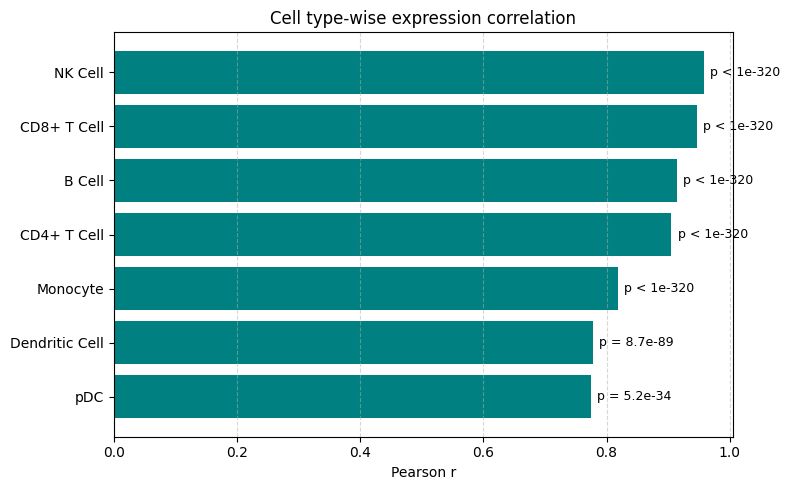

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t

def pearson_log10_pval(r, n):
    """用 t 分布手动计算 -log10(p-value)，防止 underflow 到 0."""
    dof = n - 2
    t_stat = r * np.sqrt(dof / (1 - r**2))
    pval = 2 * t.sf(np.abs(t_stat), dof)
    return -np.log10(pval) if pval > 0 else 320  # capped

def compare_by_cell_type(adata_original, adata_imputed, groupby='cell_type', min_cells=3, save=None):
    results = []

    shared_cts = set(adata_original.obs[groupby]).intersection(adata_imputed.obs[groupby])

    for ct in sorted(shared_cts):
        orig = adata_original[adata_original.obs[groupby] == ct]
        imp = adata_imputed[adata_imputed.obs[groupby] == ct]

        if orig.n_obs < min_cells or imp.n_obs < min_cells:
            continue

        mean_orig = np.asarray(orig.X.mean(axis=0)).flatten()
        mean_imp  = np.asarray(imp.X.mean(axis=0)).flatten()

        r, _ = pearsonr(mean_orig, mean_imp)
        log10p = pearson_log10_pval(r, orig.n_obs)

        results.append({'cell_type': ct, 'correlation': r, '-log10(pval)': log10p})

    df = pd.DataFrame(results).sort_values('correlation', ascending=False)

    print(df)

    # 绘图
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.barh(df['cell_type'], df['correlation'], color='teal')
    ax.set_xlabel('Pearson r')
    ax.set_title('Cell type-wise expression correlation')
    ax.invert_yaxis()
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# 在柱子右侧添加 p 值注释
    for bar, neg_log_pval in zip(bars, df['-log10(pval)']):
    # 转换回 p 值并格式化
        if neg_log_pval >= 320:
            pval_str = "p < 1e-320"
        else:
            pval = 10 ** (-neg_log_pval)
            pval_str = f"p = {pval:.1e}"
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(width + 0.01, y, pval_str, va='center', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()

    # 返回或保存结果
    if save:
        df.to_csv(save, index=False)
        print(f"✅ 保存到: {save}")
    return df
df_celltype_corr = compare_by_cell_type(
    adata_original=adata_original_rna,
    adata_imputed=adata_atac_imputed_rna,
    groupby='final_ct',          # 默认是 cell_type，也可以换成 subclass 等
)


/tmp/ipykernel_2556344/2865109925.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_avg = gene_data.groupby(groupby).mean().T
/tmp/ipykernel_2556344/2865109925.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_avg = gene_data.groupby(groupby).mean().T


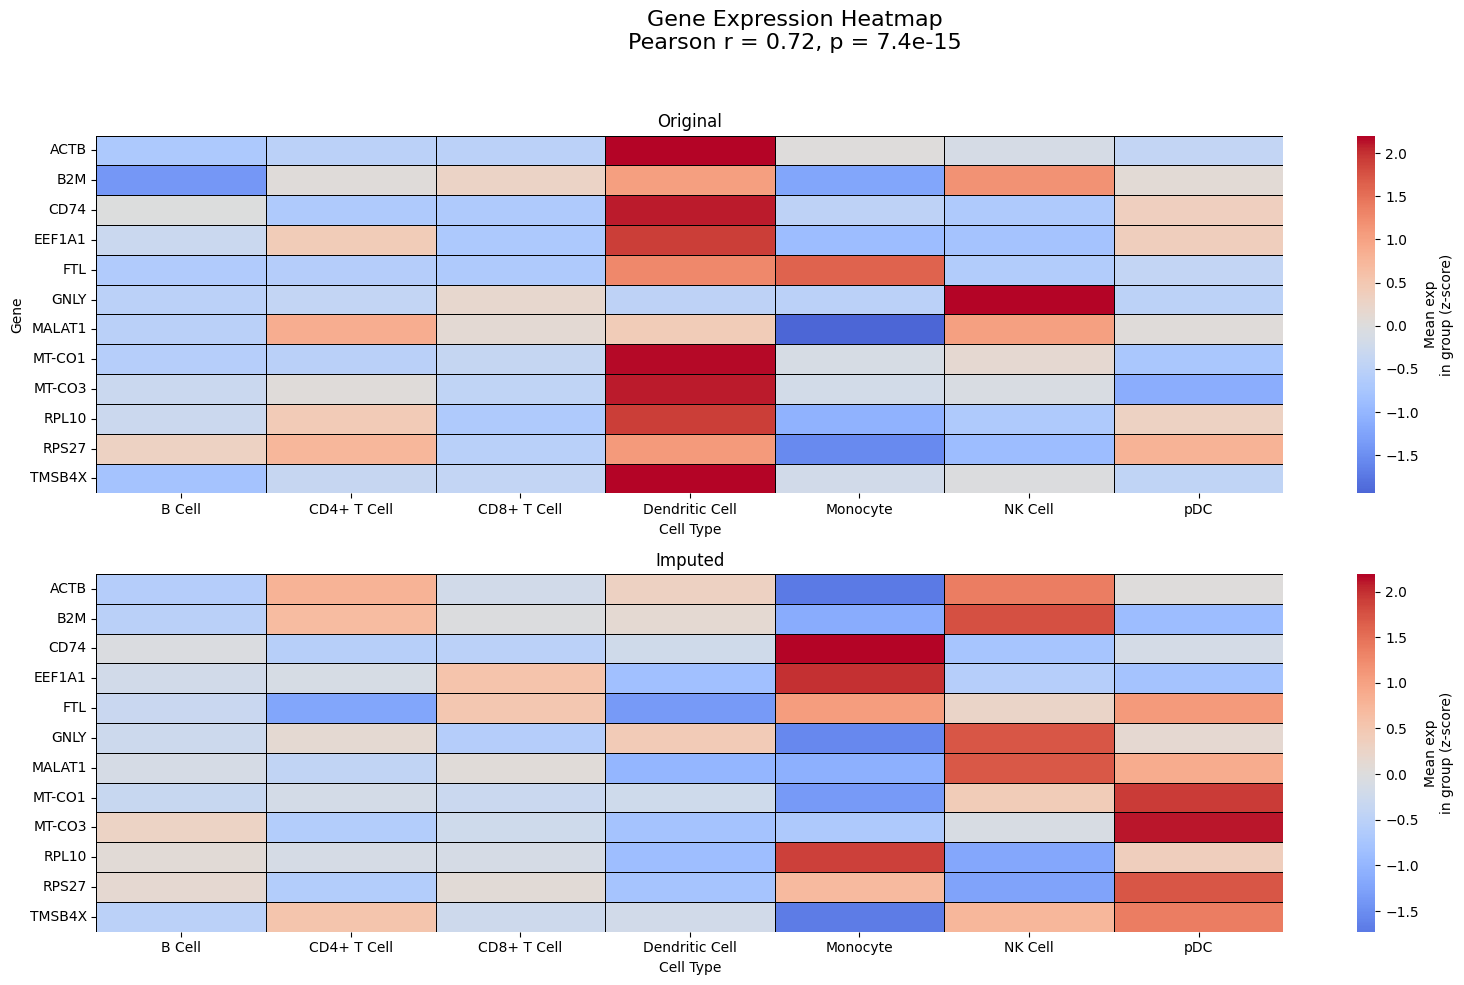

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 获取公共 cell types（两个对象都存在的）
cell_types_orig = adata_original_rna.obs['final_ct'].unique()
cell_types_impt = adata_atac_imputed_rna.obs['final_ct'].unique()
common_cell_types = sorted(list(set(cell_types_orig) & set(cell_types_impt)))

# 存储每个 cell type 的 top 5 gene 和对应均值
top_genes = set()

# 遍历 cell types 获取 top genes
for ct in common_cell_types:
    cells = adata_original_rna.obs['final_ct'] == ct
    adata_ct = adata_original_rna[cells]

    gene_means = adata_ct.X.mean(axis=0)
    gene_means = gene_means.A1 if hasattr(gene_means, 'A1') else np.asarray(gene_means).flatten()

    nonzero_idx = gene_means > 0
    if np.sum(nonzero_idx) < 5:
        print(f"❌ 跳过 {ct}：有效基因数 < 5")
        continue

    gene_means = gene_means[nonzero_idx]
    gene_names = adata_ct.var_names[nonzero_idx]
    top5 = gene_names[np.argsort(gene_means)[-5:]]
    top_genes.update(top5)

top_genes = sorted(list(top_genes))  # 去重后排序

# 计算每个细胞类型中这些基因的表达均值（原始和imputed）
def get_group_avg(adata, genes, groupby="final_ct"):
    gene_data = adata[:, genes].to_df()
    gene_data[groupby] = adata.obs[groupby].values
    group_avg = gene_data.groupby(groupby).mean().T
    return group_avg[[ct for ct in common_cell_types if ct in group_avg.columns]]

avg_expr_orig = get_group_avg(adata_original_rna, top_genes)
avg_expr_impt = get_group_avg(adata_atac_imputed_rna, top_genes)

# 计算整体 Pearson 相关性
corr, pval = pearsonr(avg_expr_orig.values.flatten(), avg_expr_impt.values.flatten())

def zscore(df):
    mean = df.mean(axis=1)  # Series
    std = df.std(axis=1)    # Series
    # Reshape to allow broadcasting along columns:
    return (df.subtract(mean, axis=0)).div(std, axis=0)


z_orig = zscore(avg_expr_orig)
z_impt = zscore(avg_expr_impt)

# 合并用于绘图
'''combined = pd.concat([z_orig, z_impt], keys=["Original", "Imputed"], axis=0)

# 绘图
plt.figure(figsize=(12, 10))
sns.heatmap(
    combined,
    cmap="coolwarm", center=0,
    cbar_kws={"label": "Mean exp\nin group (z-score)"},
    linewidths=0.5, linecolor='black'
)
plt.title(f"Gene Expression Heatmap\nPearson r = {corr:.2f}, p = {pval:.1e}", fontsize=14)
plt.xlabel("Cell Type")
plt.ylabel("")
plt.tight_layout()
plt.show()'''

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

# Original heatmap
sns.heatmap(
    z_orig,
    cmap="coolwarm", center=0,
    cbar_kws={"label": "Mean exp\nin group (z-score)"},
    linewidths=0.5, linecolor='black',
    ax=axes[0]
)
axes[0].set_title("Original")
axes[0].set_xlabel("Cell Type")
axes[0].set_ylabel("Gene")

# Imputed heatmap
sns.heatmap(
    z_impt,
    cmap="coolwarm", center=0,
    cbar_kws={"label": "Mean exp\nin group (z-score)"},
    linewidths=0.5, linecolor='black',
    ax=axes[1]
)
axes[1].set_title("Imputed")
axes[1].set_xlabel("Cell Type")
axes[1].set_ylabel("")

# 整体标题
fig.suptitle(f"Gene Expression Heatmap\nPearson r = {corr:.2f}, p = {pval:.1e}", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

